In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sqlite3


In [38]:
con = sqlite3.connect('users_lovoo_v3.db')

cur = con.cursor()

# Find the tables in the database
for row in cur.execute("SELECT name FROM sqlite_master where type='table'"):
    print(row)

('objects',)
('api',)


From the above, we can see that there are two tables in the database.  Next, I would like to know how the tables differ. Specifically, I would like to know what kind of information the tables contain and how much information is in each. I figure this out by looking at the columns in each and the number of rows in each table.

In [39]:
cur.execute('SELECT * FROM objects')
obj_cols = [description[0] for description in cur.description]

cur.execute('SELECT * FROM api')
api_cols = [description[0] for description in cur.description]
shared_cols = []
not_in_api = []
print('In objects table but not api')
for col in obj_cols:
    if col not in api_cols:
        not_in_api.append(col)
    else:
        shared_cols.append(col)
print(not_in_api)

print('\nIn api table but not objects')
not_in_obj = []
for col in api_cols:
    if col not in obj_cols:
        not_in_obj.append(col)
print(not_in_obj)


print('\nIn both tables')
print(shared_cols)

In objects table but not api
['connectedToFacebook', 'isVIP', 'isVerified', 'lastOnline', 'lastOnlineTs', 'locationCity', 'locationCitySub', 'userInfo_visitDate', 'countDetails', 'flirtstar', 'freshman', 'hasBirthday', 'highlighted', 'locked', 'mobile', 'online']

In api table but not objects
['genderLooking', 'counts_details', 'counts_fans', 'counts_g', 'country', 'location', 'isFlirtstar', 'isHighlighted', 'isInfluencer', 'isMobile', 'isNew', 'isOnline', 'isVip', 'verified', 'shareProfileEnabled', 'lastOnlineDate', 'lastOnlineTime', 'birthd', 'freetext']

In both tables
['gender', 'age', 'name', 'counts_pictures', 'counts_profileVisits', 'counts_kisses', 'flirtInterests_chat', 'flirtInterests_friends', 'flirtInterests_date', 'lang_count', 'lang_fr', 'lang_en', 'lang_de', 'lang_it', 'lang_es', 'lang_pt', 'city', 'crypt', 'distance', 'whazzup', 'userId', 'pictureId', 'isSystemProfile']


In [40]:
obj_table_users = list(cur.execute("SELECT COUNT(userID) FROM objects"))[0][0]

api_table_users = list(cur.execute("SELECT COUNT(userID) FROM api"))[0][0]
print(f'The object table has {obj_table_users} rows.')
print(f'The api table has {api_table_users} rows.')

The object table has 2940 rows.
The api table has 3992 rows.


A few conclusions can be drawn from the above information. First, the api table contains a little over 1000 more users than the objects table. Additionally, the api table contains some interesting information that the objects table does not, like the genderLooking column. However, some of the columns that do not overlap between the two tables seem to be an issue of name mismatch (ex. flirtstar vs isFlirtstar), rather than the information truly only being in one table.

I will handle this in a couple of steps. First, I will union the two tables, aliasing columns as necessary. Then I will use a left join to add the genderLooking column, so I can keep rows that do not have that field.

In [41]:
obj_cols = 'isVIP as isVip, isVerified as verified, flirtstar as isFlirtstar, highlighted as isHighlighted, hasBirthday'
api_cols = 'isVip, verified, isFlirtstar, isHighlighted, birthd as hasBirthday'


An example of how these columns might be joined is below. Note I use a UNION instead of a UNION ALL just to save space.

In [42]:
list(cur.execute(f"SELECT {obj_cols} FROM objects UNION SELECT {api_cols} FROM api"))

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 1, 1, 0),
 (1, 0, 0, 0, 0),
 (1, 1, 0, 0, 0),
 (1, 1, 1, 1, 0),
 ('false', 'false', 'false', 'false', 'false'),
 ('false', 'false', 'false', 'false', 'true'),
 ('false', 'false', 'true', 'true', 'false'),
 ('false', 'true', 'false', 'false', 'false'),
 ('false', 'true', 'false', 'false', 'true'),
 ('false', 'true', 'true', 'true', 'false'),
 ('true', 'false', 'false', 'false', 'false'),
 ('true', 'false', 'true', 'true', 'false'),
 ('true', 'true', 'false', 'false', 'false'),
 ('true', 'true', 'true', 'true', 'false')]

The next issue we run into is that the api rows are integer encoded while the object rows are boolean values. Eventually these will all need to have the same datatypes. I fix this with a CASE statement.

In [43]:
def bool_to_int_case(field):
    '''
    Converts one hot encoded fields in a SQL table into boolean datatypes using a case statement.
    '''
    return f"CASE {field} WHEN 'false' THEN 0 WHEN 'true' THEN 1 END"

# Redefine the object columns
obj_cols = f"{bool_to_int_case('isVIP')} as isVip, {bool_to_int_case('isVerified')} as verified, {bool_to_int_case('flirtstar')} as isFlirtstar, {bool_to_int_case('highlighted')} as isHighlighted, {bool_to_int_case('hasBirthday')} as hasBirthday"

api_shared = ', '.join(['api.'+col for col in shared_cols])
obj_shared = ', '.join(['objects.'+col for col in shared_cols])

In [44]:
api_shared

'api.gender, api.age, api.name, api.counts_pictures, api.counts_profileVisits, api.counts_kisses, api.flirtInterests_chat, api.flirtInterests_friends, api.flirtInterests_date, api.lang_count, api.lang_fr, api.lang_en, api.lang_de, api.lang_it, api.lang_es, api.lang_pt, api.city, api.crypt, api.distance, api.whazzup, api.userId, api.pictureId, api.isSystemProfile'

We can then join the columns

In [45]:
query = f"WITH users AS (SELECT *\
                FROM (SELECT {obj_shared}, {obj_cols} \
                FROM objects \
                UNION \
                SELECT {api_shared}, {api_cols}\
                FROM api))\
        SELECT * FROM users\
        LEFT JOIN (SELECT DISTINCT api.userId, api.genderLooking AS attraction FROM api) as t\
        ON t.userId = users.userId\
        GROUP BY t.userId, pictureId;"



df = pd.read_sql_query(query, con)

# Close the connection to the database
con.close()

In [46]:
df.sort_values(by='pictureId', ascending=False).head()

,gender,age,name,counts_pictures,counts_profileVisits,counts_kisses,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,lang_count,...,userId,pictureId,isSystemProfile,isVip,verified,isFlirtstar,isHighlighted,hasBirthday,userId,attraction
3999,F,23,Eni**n,8,8702,142,true,true,true,2,...,CRYsH4q+r4fCkC8+leJqDdJQtbUNQGCyqLx36aDsEzC5b9...,e532a6060fe4e5902c66086d905a9d53,,0,0,0,0,0,CRYsH4q+r4fCkC8+leJqDdJQtbUNQGCyqLx36aDsEzC5b9...,M
7,F,23,Eni**n,8,8681,141,true,true,true,2,...,CRYohLWFV8BkxZIvOom42Cwo3ysdViv+oTosUAOQkLKHTM...,e532a6060fe4e5902c66086d905a9d53,false,0,0,0,0,0,None,None
3973,F,20,ja**i,19,9760,359,true,true,true,1,...,CRYKMeFC4NTG641GN+wrkszgUSS8aHZ8YZQYAxyIUJ2IHv...,e05ec5709ac69271411c0a10a2591e72,,0,0,0,0,0,CRYKMeFC4NTG641GN+wrkszgUSS8aHZ8YZQYAxyIUJ2IHv...,M
3959,F,23,Eni**n,9,8904,143,true,true,true,2,...,CRY0HaQXrVG0M5KpAEJr35iE4XUAFXQ9hy2NaGT2XyxXIL...,dc186f3855343c9f096c484f6d363aac,,0,0,0,0,0,CRY0HaQXrVG0M5KpAEJr35iE4XUAFXQ9hy2NaGT2XyxXIL...,M
3979,F,23,Eni**n,9,8904,143,true,true,true,2,...,CRYUeFme1yutTSpdjOM5S9LPaGI4qhaqgsjI7WNxrjfa0a...,dc186f3855343c9f096c484f6d363aac,,0,0,0,0,0,CRYUeFme1yutTSpdjOM5S9LPaGI4qhaqgsjI7WNxrjfa0a...,M


From the above, we can see two issues. First, some rows have identical pictureId values but unique userId values. Second, some boolean features need to be integer encoded.

# Data Cleaning

## Dropping Duplicate Rows
Rows with repeated pictureId values will be dropped. Such rows likely exist for one of two reasons. First, a person may make, delete, then remake an account using the same picture. Second, bots may make profiles using the same picture. Either way, the repeated pictureIds are rightly viewed as contaminating the data.

In [47]:
df = df.drop_duplicates(subset='pictureId', keep='first')

With this done, we can also drop columns with info about profiles and users. They no longer serve any use.

In [48]:
df = df.drop(['name', 'userId', 'pictureId', 'crypt', 'distance'], axis=1)

## Fixing DataTypes
The primary concern here is integer encoding boolean values.

In [49]:
sql_bool_cols = []

for col in df.columns:
    unique_vals = df[col].unique()
    if df[col].dtype =='object':
        if "true" in unique_vals or "false" in unique_vals:
            sql_bool_cols.append(col)

print('The following columns have boolean values that need to be integer encoded:')
print(sql_bool_cols)

The following columns have boolean values that need to be integer encoded:
['flirtInterests_chat', 'flirtInterests_friends', 'flirtInterests_date', 'lang_fr', 'lang_en', 'lang_de', 'lang_it', 'lang_es', 'lang_pt', 'isSystemProfile']


In [50]:
def bool_mapper(value):
    if value == 'true':
        return 1
    elif value == 'false':
        return 0
    else:
        return value

for col in sql_bool_cols:
    df[col] = df[col].apply(lambda x: bool_mapper(x))

## Deleting System Profiles
We do not want to look at system profiles, only real, unique users.

In [51]:
df['isSystemProfile'].unique()

array([0, '', '1'], dtype=object)

In [52]:
df[df['isSystemProfile'] == '1']

,gender,age,counts_pictures,counts_profileVisits,counts_kisses,flirtInterests_chat,flirtInterests_friends,flirtInterests_date,lang_count,lang_fr,...,lang_pt,city,whazzup,isSystemProfile,isVip,verified,isFlirtstar,isHighlighted,hasBirthday,attraction
1121,F,28,5,0,0,0,0,0,5,1,...,1,London,Welcome to LOVOO,1,0,1,0,0,0,both
1125,F,18,1,0,0,0,0,0,1,0,...,0,Dresden,LOVOO Support,1,0,0,0,0,0,both


In [53]:
df = df[df['isSystemProfile'] != '1']

We can then drop this feature, as it has no further use.

In [54]:
df = df.drop(['isSystemProfile'], axis=1)

## Binary Encode "whazzup" feature
The whazzup feature contains a short message from the user. THe primary issue with this message is that it can be in any number of languages. This makes it difficult to quantify information about the text, ex. through vectorization or out of the box sentiment analysis models. Second, the text contains emojis, urls, typos, etc. This makes it difficult to translate all of the text into a single language. As such, the feature will be binary encoded - 1 if the user has a whazzup message and 0 if they do not.

In [55]:
df['whazzup'].head(5)

0    Je ne suis pas compliquée...je sais ce que je ...
1                                                     
2                                     Fiesta and sport
3                                                     
4        tous des créatures de Dieu, y'a pas de VIP!!!
Name: whazzup, dtype: object

Above we can see two languages and a typo using elipses.

In [56]:
def whazzup_to_bool(message):
    message = message.strip()
    if message == '':
        return 0
    else:
        return 1

df['whazzup'] = df['whazzup'].apply(lambda x: whazzup_to_bool(x))

# Exploratory Data Analysis

In [57]:
boolean_features = ['flirtInterests_chat', 'flirtInterests_friends',
       'flirtInterests_date','lang_fr', 'lang_en', 'lang_de',
       'lang_it', 'lang_es', 'lang_pt', 'isVip', 'verified', 'isFlirtstar', 'isHighlighted', 'hasBirthday',
       'attraction', 'whazzup']

# non-boolean categorical features
categorical_features = ['city']

numerical_features = ['age', 'counts_pictures', 'counts_profileVisits', 'counts_kisses', 'lang_count']

## Univariate

## Boolean Features

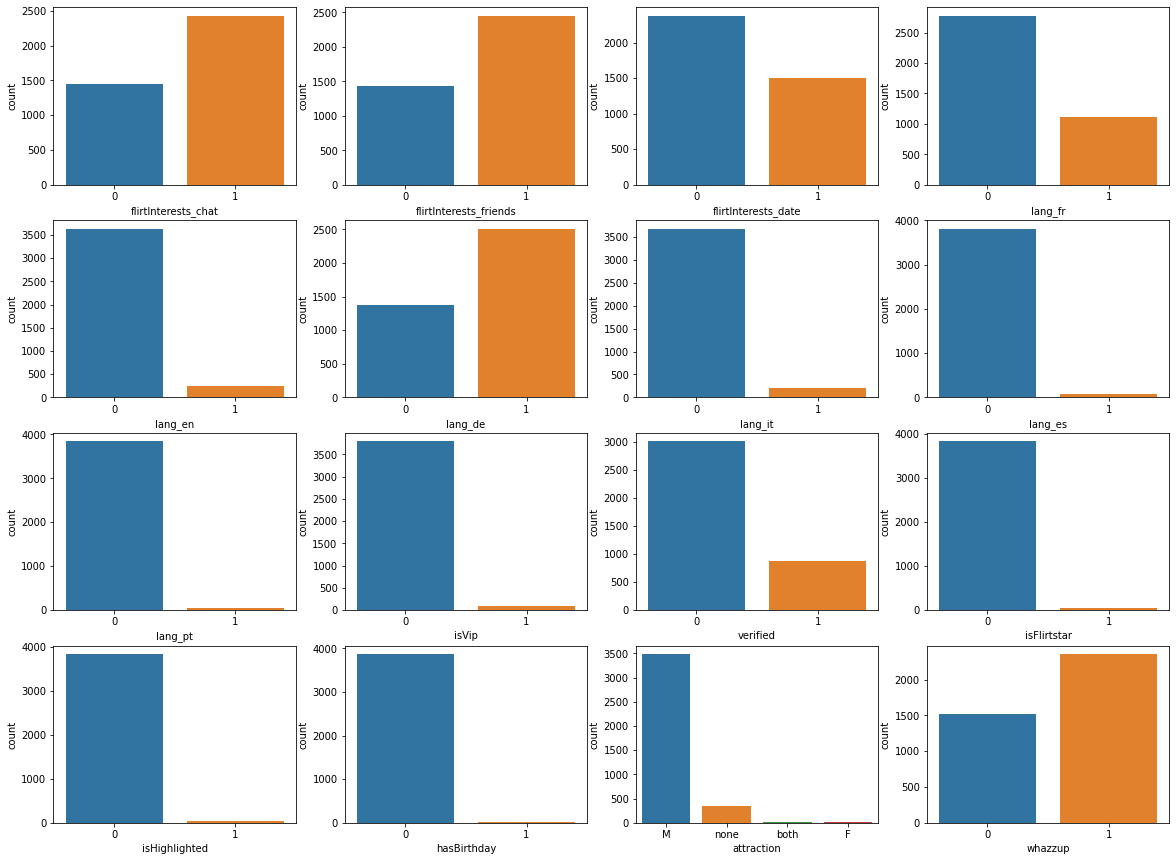

In [58]:
fig, axes = plt.subplots(4, 4, figsize=(20,15))

for col, ax in zip(boolean_features, np.ravel(axes)):
    sns.countplot(data=df, x=col, ax=ax)

A couple of things stick out here. First, lots of users speak german, but many do not speak any other language the company tracks. Lovoo is run by a German company, so this an unsurprising result. Second, it looks like most users do not engage with many of the features - they do not list their birthday, they do not use the (likely premium) VIP feature, and so on. Additionally, many users are not verified. A fair number of users, over a third, do not have a whazzup message.

## Users in Each City

In [59]:
city_groupby = df.groupby('city').count().sort_values('age', ascending=False)
city_names = city_groupby.index
city_counts = city_groupby.values[:,0]


There are a total of 1420 cities, but the bar plot below only shows the 20 most common of them.


Text(0.5, 0, 'users in city')

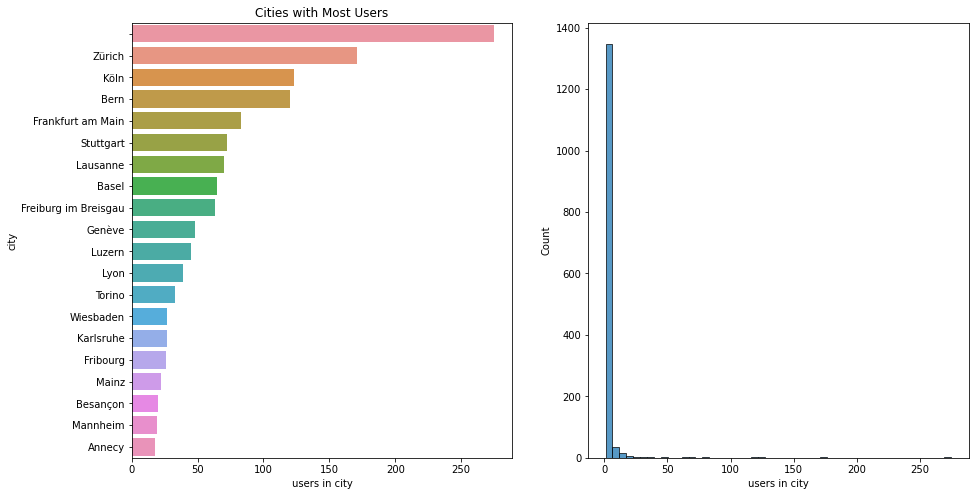

In [60]:
top_cities = 20
print(f'There are a total of {len(city_names)} cities, but the bar plot below only shows the {top_cities} most common of them.')

fig, axes = plt.subplots(1, 2, figsize=(15,8))
sns.barplot(y=city_names[:top_cities], x=city_counts[:top_cities], orient='h', ax=axes[0])
axes[0].set_title('Cities with Most Users')
axes[0].set_xlabel('users in city')


sns.histplot(x=city_counts, ax=axes[1], bins=50)
axes[1].set_xlabel('Distribution of Users in Cities')
axes[1].set_xlabel('users in city')


While some German and Swiss cities have a moderate number of users, the vast, vast majority have very few users. Additionally, about 250 users do not list a city of residence at all. All of this suggests that the city feature is not of much use.

# Numerical Features

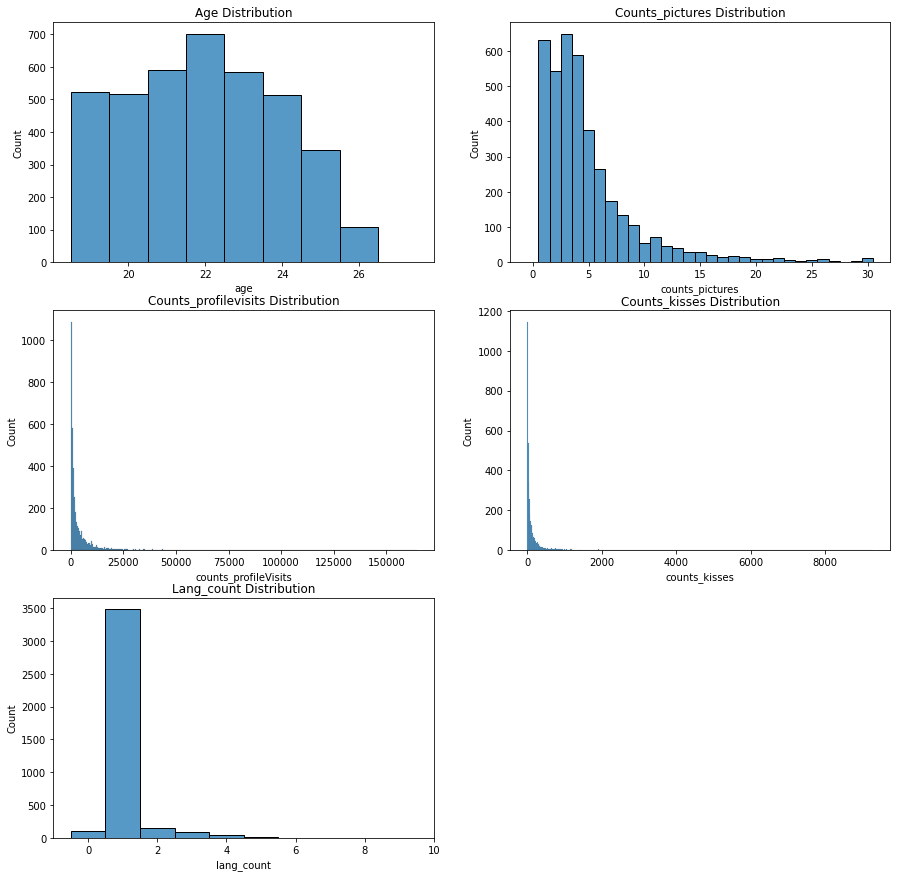

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for col, ax in zip(numerical_features, np.ravel(axes)):
    if 'profile' in col.lower() or 'kisses' in col.lower():
        sns.histplot(data=df, x=col, ax=ax, discrete=False)
        ax.set_title(f'{col.capitalize()} Distribution')
    else:
        sns.histplot(data=df, x=col, ax=ax, discrete=True)
        ax.set_title(f'{col.capitalize()} Distribution')

axes[-1][-1].set_axis_off()

All of these look more or less as expected. The userbase skews young. This is not surporising given it is a dating app, and may be even less so depending on when the data was collected and at what age users tend to marry/pair up in users' countries. The number of pictures is also as expected. A substantial number of users have five or less. Beyond that, and the number of users drops off substantially. The shape of the number of visits and kisses (esentially "likes") are intuitive as well. A large portion of people get relatively little interaction, and very few get a lot. An issue with either of these is that it is difficult to tell what a reasonable maximum number of visits or kisses is, thus it is difficult to identify outliers. This is even moreso the case with no information about how men use the site. Finally, most users are monolingual. This is again unsurprising.

# Bivariate Analysis

In [155]:
bivariate_bool_stats = {}
for col in boolean_features:
    col_grouped_stats = df[[col]+['counts_kisses']].groupby(col).agg(['mean', 'std']).values
    bivariate_bool_stats[col+'_mean'] = col_grouped_stats[:, 0]
    bivariate_bool_stats[col+'_std'] = col_grouped_stats[:, 1]
    bivariate_bool_stats[col+'_uniques'] =  df[df[col] != None][col].unique()
    bivariate_bool_stats[col+'_uniques'] = [val for val in bivariate_bool_stats[col+'_uniques'] if val != None]

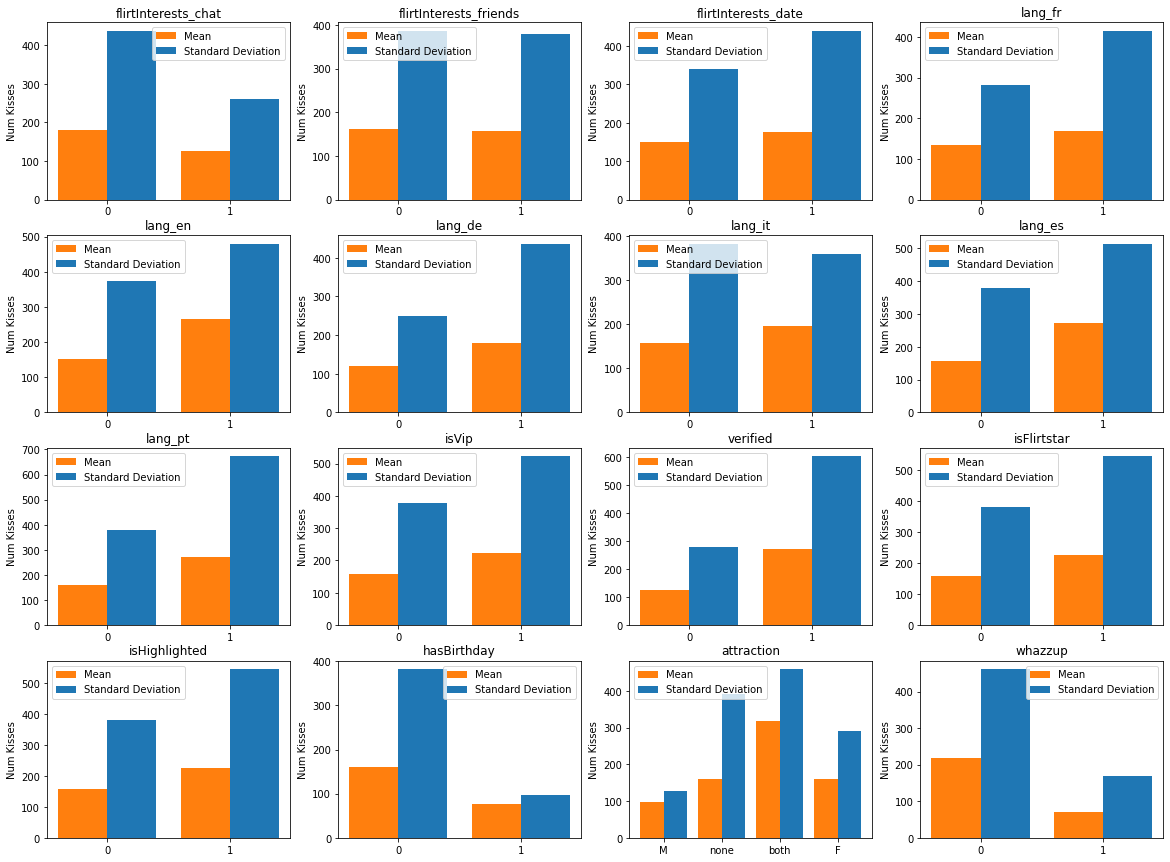

In [163]:
fig, axes = plt.subplots(4,4, figsize=(20,15))
for col, ax in zip(boolean_features, np.ravel(axes)):
    line2 = ax.bar(x=bivariate_bool_stats[col+'_uniques'], height=bivariate_bool_stats[col+'_std'], width=0.4, align='edge', label='Standard Deviation')
    line1 = ax.bar(x=bivariate_bool_stats[col+'_uniques'], height=bivariate_bool_stats[col+'_mean'], width=-0.4, align='edge', label='Mean')
    ax.set_title(col)
    ax.set_ylabel('Num Kisses')
    ax.legend(handles=[line1, line2])
    
    ax.set_xticks(bivariate_bool_stats[col+'_uniques'])

From the above, the means of various features appear to be significantly different. But note that the mean is affected by large values, which are present in the feature that counts the number of kisses each user receives. Unfortunately, it is difficult to visualize relation between the categorical features and the number of kisses in a single plot, at least without transorming the number of kisses, at which point, a good deal of interpretability is lost. The source of this issue is the distribution of the number of kisses. To visually examine large values, individual numbers of kisses are plotted againt the categorical features below.

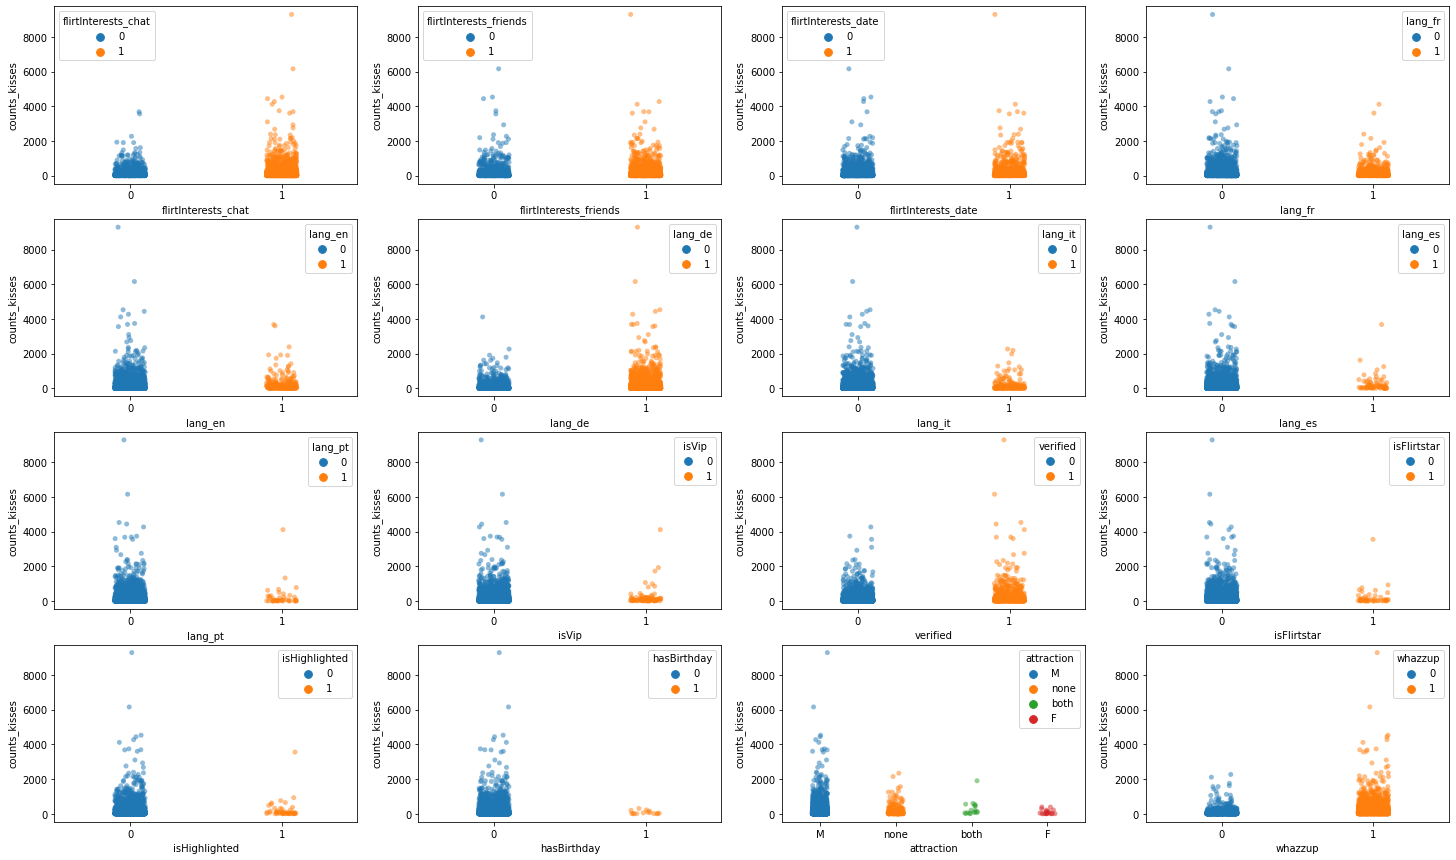

In [184]:
fig, axes = plt.subplots(4, 4, figsize=(25,15))

for col, ax in zip(boolean_features, np.ravel(axes)):
    sns.stripplot(data=df, x=col, y='counts_kisses', hue=col, alpha=0.5, ax=ax)


## Numerical Features

<AxesSubplot:>

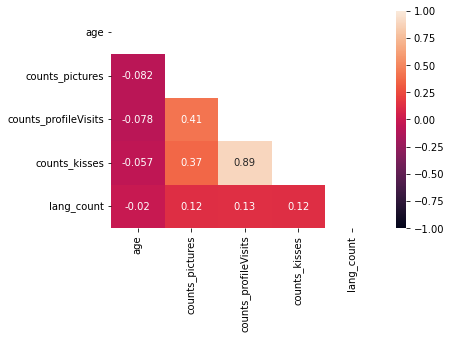

In [181]:
corr = df[numerical_features].corr()
mask = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=mask)

There are some notable correlations. The number of kisses slightly increases with the number of languges spoken - which indicates a larger dating pool - and more moderately with the number of pictures a user has. The number of kisses also positively correlates with profile visits, which makes sense given kissing requires profile visits. Language count also positively correlates with profile visits, likely also a result of a user that speaks more language having a larger dating pool.

Less obvious correlations are those between profile visits and number of pictures, as well as the slight correlation between languages spoken and number of pictures.

Age does not have substantial correlations with anything.

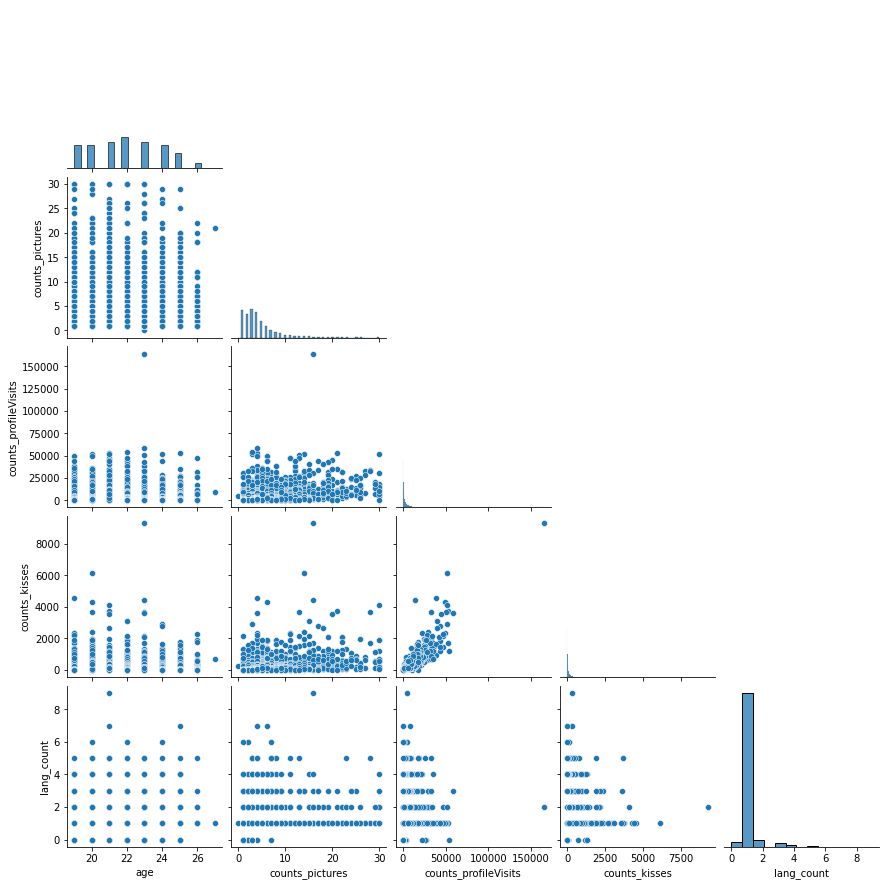

In [179]:
sns.pairplot(df[numerical_features], corner=True)
